In [1]:
import sys
import os
import pandas as pd
import sktime
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series

training_dir = os.path.join(os.path.dirname("training/"), '')
sys.path.append(training_dir)
print(training_dir)

training/


       Date  Inventory_Level
0  1/1/2017            29154
1  1/2/2017            55036
2  1/3/2017            83609
3  1/4/2017           105607
4  1/5/2017           143171


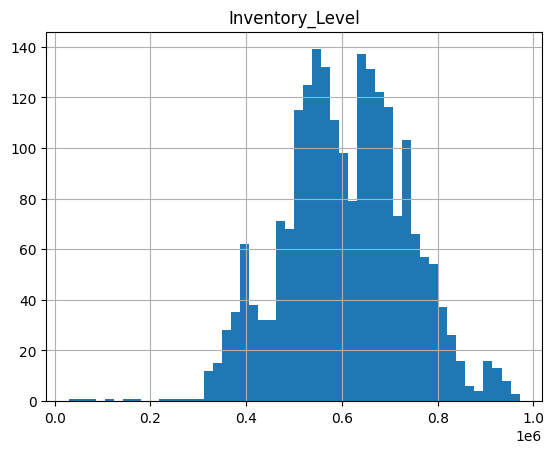

In [2]:
import matplotlib.pyplot as plt
data = pd.read_csv("src/csv/train_inventory(in).csv")
print(data.head())
data.set_index('Date', inplace=True)
data.hist(bins=50)
plt.show()


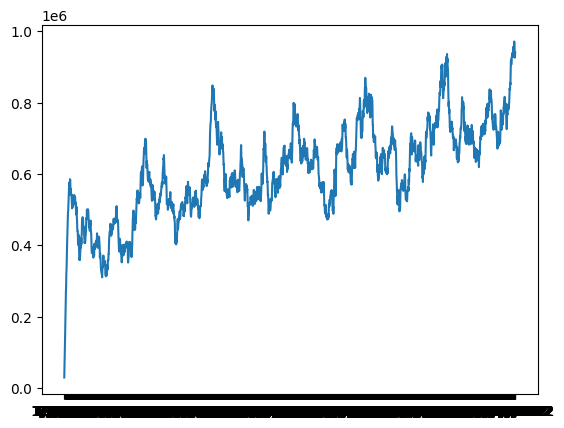

In [3]:
plt.plot(data)

In [4]:
data_inflows = pd.read_csv("src/csv/train_inventory(in).csv", parse_dates=["Date"])

/var/folders/pd/vtwfqsz51lxd0gz80_2mf69c0000gp/T/ipykernel_3325/2640611231.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = data_inflows.set_index('Date')['Inventory_Level'].asfreq('M').fillna(0)


                                    Date  Forecasted_Inventory
2023-01-31 2023-01-31 23:59:59.999999999         936502.771838
2023-02-28 2023-02-28 23:59:59.999999999         807683.949915
2023-03-31 2023-03-31 23:59:59.999999999         784581.660371
2023-04-30 2023-04-30 23:59:59.999999999         839460.870018
2023-05-31 2023-05-31 23:59:59.999999999         781440.700187
2023-06-30 2023-06-30 23:59:59.999999999         692407.438543
2023-07-31 2023-07-31 23:59:59.999999999         720978.166158
2023-08-31 2023-08-31 23:59:59.999999999         857903.205941
2023-09-30 2023-09-30 23:59:59.999999999         789909.535300
2023-10-31 2023-10-31 23:59:59.999999999         807091.194957
2023-11-30 2023-11-30 23:59:59.999999999         877006.157082
2023-12-31 2023-12-31 23:59:59.999999999         955268.056273


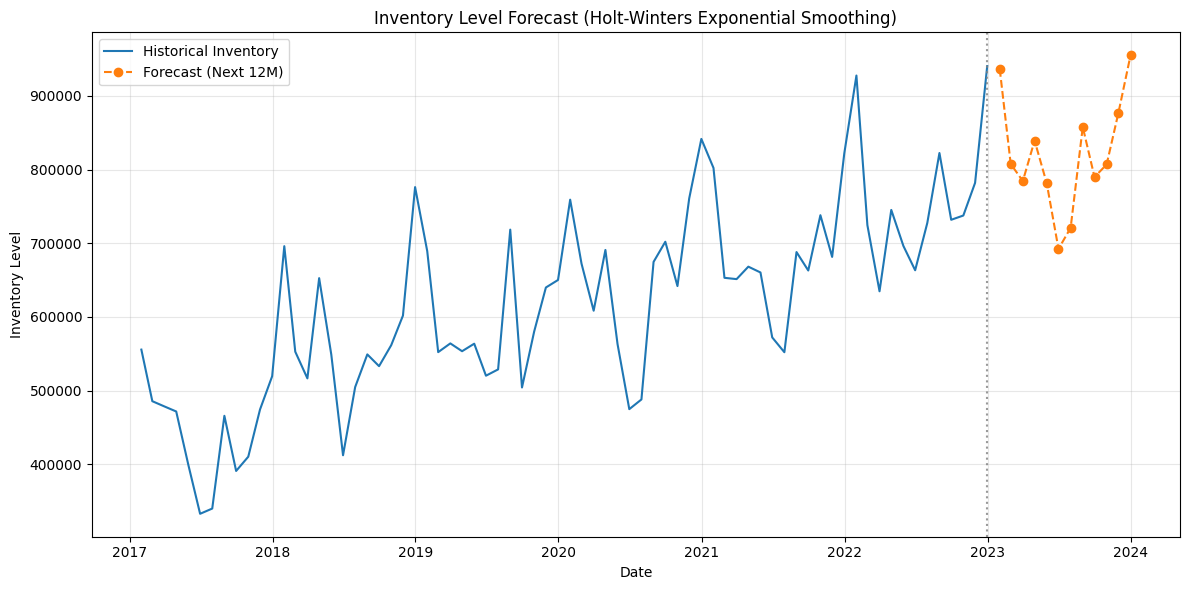

In [20]:
import pandas as pd
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

# Load data
data_inflows = pd.read_csv("src/csv/train_inventory(in).csv", parse_dates=["Date"])

# Use month-end frequency consistently
y = data_inflows.set_index('Date')['Inventory_Level'].asfreq('M').fillna(0)

# Fit model
forecaster = ExponentialSmoothing(trend='add', seasonal='add', sp=12)
forecaster.fit(y)

# Create a matching forecast horizon (month-end)
last_period = y.index[-1].to_period('M')
fh = ForecastingHorizon(
    pd.period_range(last_period + 1, periods=12, freq='M').to_timestamp(how='end'),
    is_relative=False
)

# Forecast
fcast_vals = forecaster.predict(fh).clip(lower=0)

# Combine into DataFrame
forecast_df = pd.DataFrame({'Date': fh.to_pandas(), 'Forecasted_Inventory': fcast_vals})
print(forecast_df)

fcast_vals = forecaster.predict(fh).clip(lower=0)

forecast_df_history = pd.DataFrame({
    'Date': fh.to_pandas(),
    'Forecasted_Inventory': fcast_vals
})

# --- 5. Plot historical + forecast
plt.figure(figsize=(12,6))
plt.plot(y.index, y.values, label='Historical Inventory', color='tab:blue')
plt.plot(forecast_df_history['Date'], forecast_df_history['Forecasted_Inventory'], label='Forecast (Next 12M)', color='tab:orange', linestyle='--', marker='o')

# vertical line separating history from forecast
plt.axvline(x=y.index[-1], color='gray', linestyle=':', alpha=0.8)

plt.title('Inventory Level Forecast (Holt-Winters Exponential Smoothing)')
plt.xlabel('Date')
plt.ylabel('Inventory Level')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



/var/folders/pd/vtwfqsz51lxd0gz80_2mf69c0000gp/T/ipykernel_3325/3921283131.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = monthly_inflow["Quantity"].asfreq("M").fillna(method="ffill")
/var/folders/pd/vtwfqsz51lxd0gz80_2mf69c0000gp/T/ipykernel_3325/3921283131.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = monthly_inflow["Quantity"].asfreq("M").fillna(method="ffill")


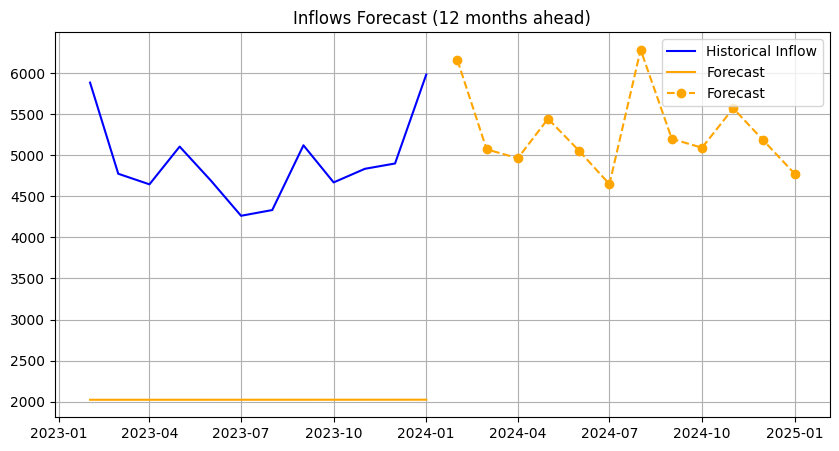

In [21]:
import pandas as pd
import numpy as np
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
import pulp
import matplotlib.pyplot as plt

# Load tuned inflow and outflow data
inflows = pd.read_csv("src/csv/tune_inflows(in).csv", parse_dates=["Date"])
outflows = pd.read_csv("src/csv/tune_outflows(in).csv", parse_dates=["Date"])

# Derive monthly aggregates
inflows["YearMonth"] = inflows["Date"].dt.to_period("M").dt.to_timestamp(how='end')
outflows["YearMonth"] = outflows["Date"].dt.to_period("M").dt.to_timestamp(how='end')

# --- Aggregate monthly inflows ---
monthly_inflow = (
    inflows.groupby("YearMonth")["Quantity"]
    .sum()
    .reset_index()
    .set_index("YearMonth")
    .sort_index()
)

# --- Ensure time index is datetime and monthly ---
monthly_inflow.index = pd.to_datetime(monthly_inflow.index)

# Convert to Series (1D)
y = monthly_inflow["Quantity"].asfreq("M").fillna(method="ffill")

# --- Fit model ---
forecaster = ExponentialSmoothing(trend="add", seasonal="add", sp=6)
forecaster.fit(y)

# --- Forecast horizon (12 months ahead) ---
last_period = y.index[-1].to_period("M")
fh = ForecastingHorizon(
    pd.period_range(last_period + 1, periods=12, freq="M").to_timestamp(how="end"),
    is_relative=False
)

# --- Forecast ---
forecast_values = forecaster.predict(fh).clip(lower=0)

# Combine results
forecast_df = pd.DataFrame({
    "Date": fh.to_pandas(),
    "Forecasted_Inflow": forecast_values
})

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y.index, y.values, label="Historical Inflow", color="blue")
plt.plot(forecast_df_history['Date'], forecast_df["Date"], forecast_df["Forecasted_Inflow"], "--o", label="Forecast", color="orange")
plt.title("Inflows Forecast (12 months ahead)")
plt.legend(); plt.grid(); plt.show()

